In [10]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from glob import glob
import h5py
import seaborn as sns

In [11]:
mat_files = sorted(glob("/Users/darshdave/Documents/BRAINTUMOR/DATASET/FILES/*.mat"))

print(f"Total files found: {len(mat_files)}")

Total files found: 3064


In [12]:
sample_path = mat_files[0]
with h5py.File(sample_path, 'r') as f:
    print(f"Keys in {sample_path}:")
    for key in f.keys():
        print(f" - {key}")

Keys in /Users/darshdave/Documents/BRAINTUMOR/DATASET/FILES/1.mat:
 - cjdata


In [13]:
with h5py.File(sample_path, 'r') as f:
    cjdata = f['cjdata']
    image = np.array(cjdata['image']).T
    label = int(np.array(cjdata['label'])[0][0])
    bbox = np.array(cjdata['bbox']).T if 'bbox' in cjdata else None

In [14]:
classes = {
    1: 'Meningioma',
    2: 'Pituitary',
    3: 'Glioma'  
}
samples = []
for path in mat_files:
    with h5py.File(path, 'r') as f:
        if 'cjdata' not in f:
            continue

        group = f['cjdata']
        image = np.array(group['image']).T
        label = int(np.array(group['label'])[0][0])

        # Get tumorMask and calculate bounding box
        mask = np.array(group['tumorMask']).T if 'tumorMask' in group else None
        if mask is not None and np.any(mask):
            y_indices, x_indices = np.where(mask > 0)
            x, y = np.min(x_indices), np.min(y_indices)
            w, h = np.max(x_indices) - x, np.max(y_indices) - y
            bbox = np.array([[x], [y], [w], [h]])
        else:
            bbox = None

        samples.append({
            'image': image,
            'label': label,
            'bbox': bbox,
            'path': os.path.basename(path)
        })


In [15]:
all_labels = [s['label'] for s in samples]
print("Label counts after filtering:")
for label in sorted(set(all_labels)):
    print(f"Label {label} ({classes.get(label, 'Unknown')}): {all_labels.count(label)}")


Label counts after filtering:
Label 1 (Meningioma): 708
Label 2 (Pituitary): 1426
Label 3 (Glioma): 930


In [16]:
# Step 1: Define valid label values and filter
valid_labels = [1, 2, 3]
samples = [s for s in samples if s['label'] in valid_labels]

# Step 2: Count labels
all_labels = [s['label'] for s in samples]
label_counts = Counter(all_labels)

# Step 3: Prepare labels and counts for plotting
labels, counts = zip(*[(classes[int(k)], v) for k, v in label_counts.items()])


In [17]:
labels, counts

(('Meningioma', 'Glioma', 'Pituitary'), (708, 930, 1426))

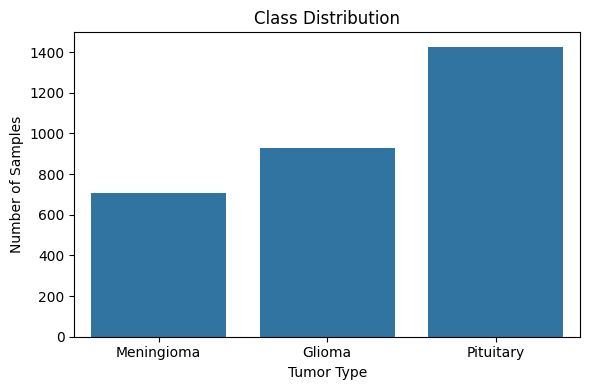

In [18]:
plt.figure(figsize=(6, 4))
sns.barplot(x=list(labels), y=list(counts))
plt.title("Class Distribution")
plt.ylabel("Number of Samples")
plt.xlabel("Tumor Type")
plt.tight_layout()
plt.show()

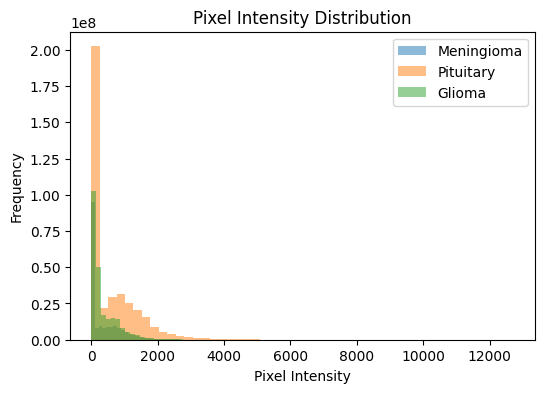

In [19]:
plt.figure(figsize=(6, 4))

for i in [1, 2, 3]:
    pixels = [s['image'].flatten() for s in samples if s['label'] == i]
    if pixels:  # safety check
        pixels = np.concatenate(pixels)
        plt.hist(pixels, bins=50, alpha=0.5, label=classes[i])

plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()



🔍 Inspecting Bounding Box Values for Shown Samples:
Class: Meningioma, File: 1.mat
 → BBox shape: (4, 1)
 → BBox values: [267 176 112  76]
Class: Meningioma, File: 10.mat
 → BBox shape: (4, 1)
 → BBox values: [236 251  63  73]
Class: Glioma, File: 1000.mat
 → BBox shape: (4, 1)
 → BBox values: [225 204  49  36]
Class: Glioma, File: 1001.mat
 → BBox shape: (4, 1)
 → BBox values: [225 203  54  39]
Class: Pituitary, File: 1841.mat
 → BBox shape: (4, 1)
 → BBox values: [285 183  51  24]
Class: Pituitary, File: 1842.mat
 → BBox shape: (4, 1)
 → BBox values: [285  89  66  77]


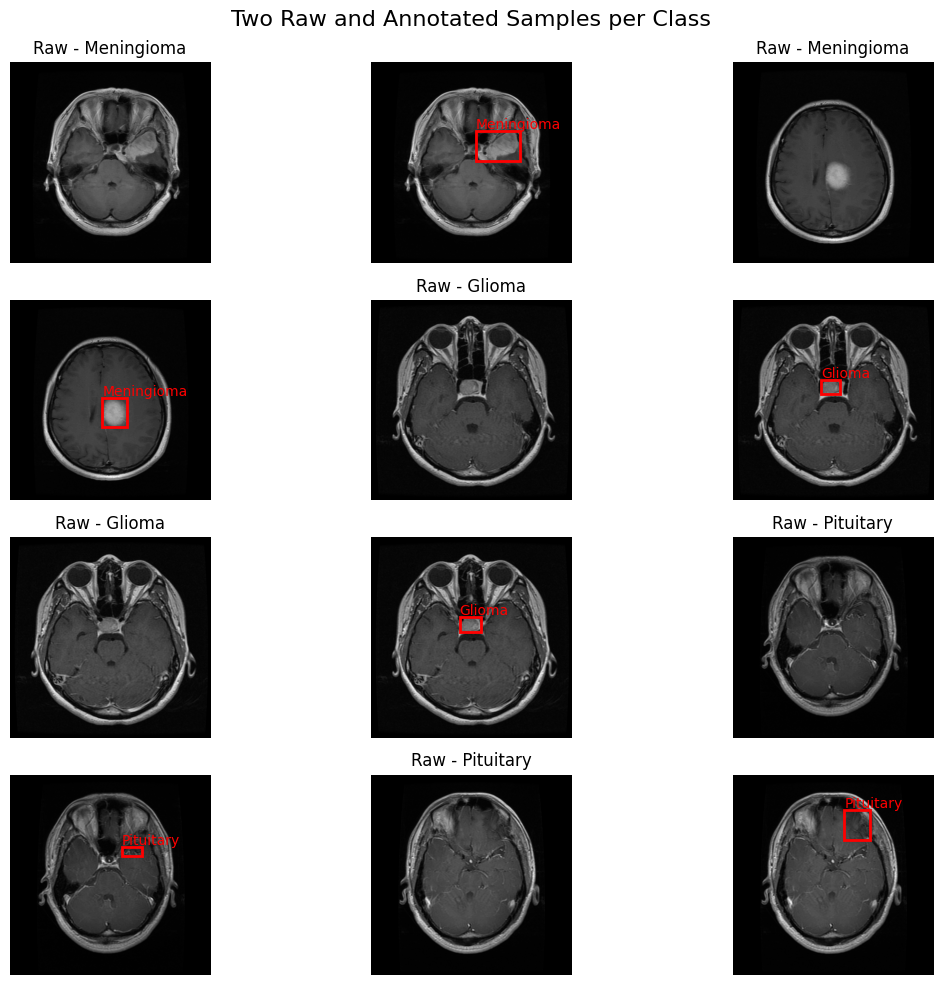

In [20]:
# Helper function to display raw image
def show_raw(image, label):
    plt.imshow(image, cmap='gray')
    plt.title(f"Raw - {classes[label]}")
    plt.axis('off')

# Helper function to display annotated image with bbox
def show_annotated(image, label, bbox):
    plt.imshow(image, cmap='gray')
    
    if bbox is not None and bbox.shape == (4, 1):
        x, y, w, h = map(int, bbox.squeeze())
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', linewidth=2))
        plt.text(x, y-5, f"{classes[label]}", color='red', fontsize=10)
    else:
        plt.title(f"{classes[label]} - No BBox", color='gray')
    
    plt.axis('off')

# 🔍 Inspect the computed bounding boxes
print("\n🔍 Inspecting Bounding Box Values for Shown Samples:")
shown_debug = {1: 0, 2: 0, 3: 0}
for s in samples:
    lbl = s['label']
    if shown_debug[lbl] < 2:
        print(f"Class: {classes[lbl]}, File: {s['path']}")
        if s['bbox'] is not None:
            print(" → BBox shape:", s['bbox'].shape)
            print(" → BBox values:", s['bbox'].squeeze())
        else:
            print(" → BBox: None")
        shown_debug[lbl] += 1
    if all([shown_debug[l] >= 2 for l in [1, 2, 3]]):
        break

# 🖼️ Plot 2 raw + 2 annotated images per class
plt.figure(figsize=(12, 10))
shown = {1: 0, 2: 0, 3: 0}
i = 1

for s in samples:
    lbl = s['label']
    if shown[lbl] < 2:
        # Raw image
        plt.subplot(4, 3, i)
        show_raw(s['image'], lbl)
        i += 1

        # Annotated image with bbox
        plt.subplot(4, 3, i)
        show_annotated(s['image'], lbl, s['bbox'])
        i += 1

        shown[lbl] += 1

    if i > 12:
        break

plt.suptitle("Two Raw and Annotated Samples per Class", fontsize=16)
plt.tight_layout()
plt.show()


In [21]:
cvind_path = '/Users/darshdave/Documents/BRAINTUMOR/DATASET/cvind.mat'
with h5py.File(cvind_path, 'r') as f:
    for key in f.keys():
        data = np.array(f[key])
        print(f"{key}: shape = {data.shape}, dtype = {data.dtype}")


cvind: shape = (1, 3064), dtype = float64
